Keyboard patterns database. 10 features. 4 classes.
Stream mode with pool size = 150



METHOD: Static lp as classifier
Execution time:  0.4420808816499648
Average micro-F1: 0.765625
Average Accuracy:  63.4875
Standard Deviation:  12.0854165733
Variance:  146.05729375


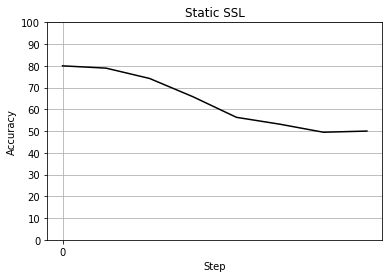

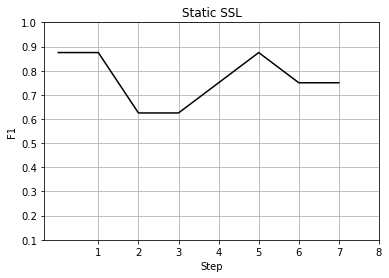




METHOD: Sliding lp as classifier


C:\Users\raul\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time:  0.4790696627047305
Average micro-F1: 0.765625
Average Accuracy:  72.89375
Standard Deviation:  6.35978957494
Variance:  40.4469234375


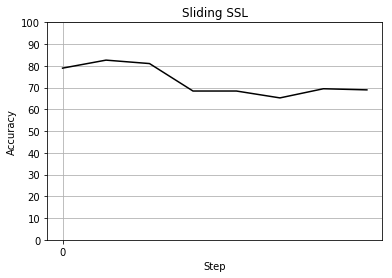

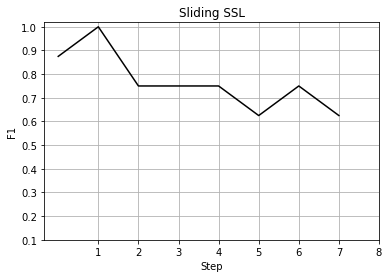




METHOD: Incremental lp as classifier
Execution time:  17.41378423500763
Average micro-F1: 0.890625
Average Accuracy:  84.3425
Standard Deviation:  3.53838858098
Variance:  12.52019375


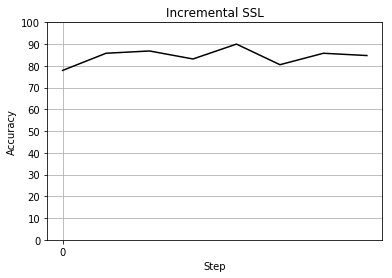

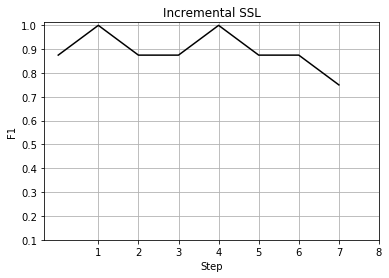




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  0.5204452022594346
Average micro-F1: 0.890625
Average Accuracy:  85.5925
Standard Deviation:  3.29570838364
Variance:  10.86169375


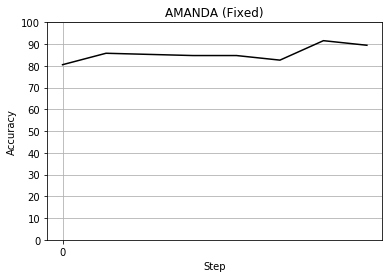

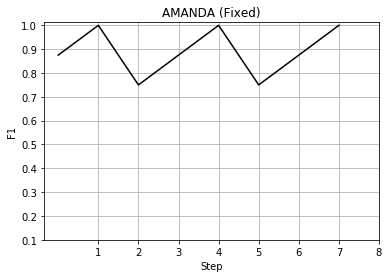




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
'float' object is not iterable
METHOD: SCARGC with 1-NN


C:\Users\raul\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Execution time:  2.542291686255112
Average micro-F1: 0.53125
Average Accuracy:  52.89375
Standard Deviation:  9.23323742993
Variance:  85.2526734375


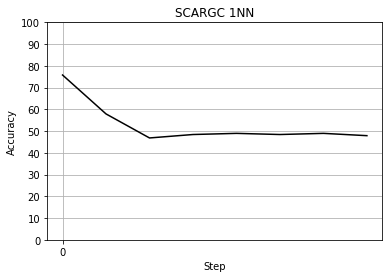

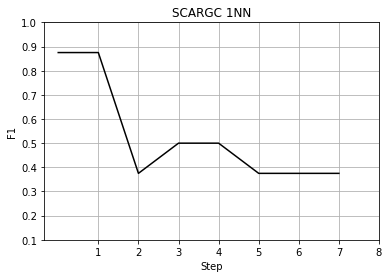

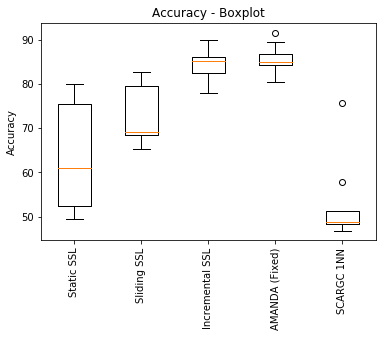

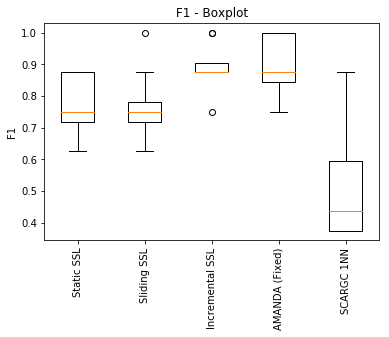

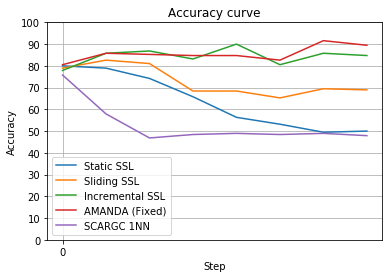

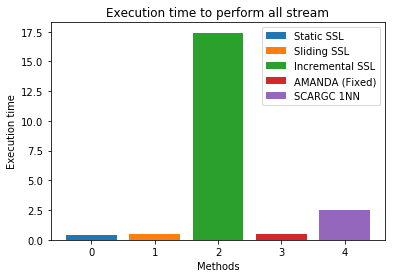

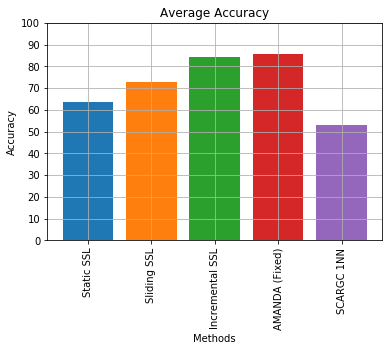

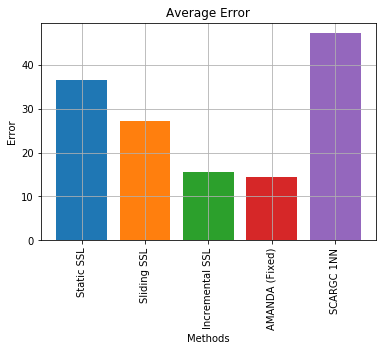

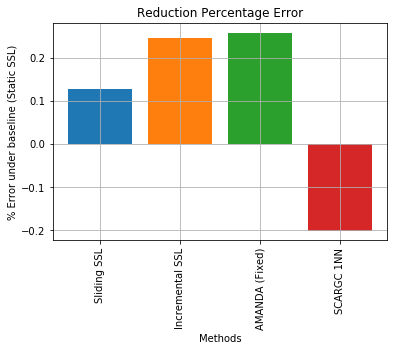

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import scargc_1NN


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 8
    poolSize = 150
    isBatchMode = False # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = {}
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadKeystroke(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 2, 0.9, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier)

    # SCARGC 1NN (Python version)
    experiments[5] = Experiment(scargc_1NN, 12) 
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()